In [1]:
import numpy as np
import pandas as pd

import altair as alt

In [5]:
df = pd.read_csv('data/grant_complete.csv', comment='#')
df = df.loc[(df['year']==1987) & (df['species']=='scandens'), :]
df = df.drop_duplicates(subset=['band'])
df = df[['beak length (mm)', 'beak depth (mm)']]

dots = alt.Chart(df
        ).mark_point(
        ).encode(
            alt.X('beak length (mm):Q', scale=alt.Scale(zero=False)),
            alt.Y('beak depth (mm):Q', scale=alt.Scale(zero=False))
        )

In [6]:
beak_length = df['beak length (mm)'].values
beak_depth = df['beak depth (mm)'].values

# function for a linear regression, polyfit degree=1
np.polyfit(beak_length, beak_depth, deg=1)

array([0.26225889, 5.4168527 ])

This array shows you the slope (0.26..) and y-intercept (5.41..)

In [7]:
slope, intercept = np.polyfit(beak_length, beak_depth, deg=1)

In [8]:
slope

0.262258885049905

In [9]:
intercept

5.416852701227372

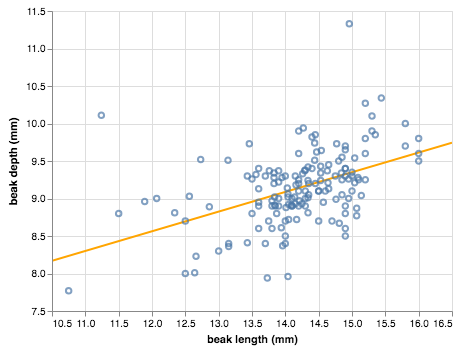

In [15]:
# Make a dataframe to plot the line
x = np.array([10.5, 16.5])
y = slope * x + intercept
df_line = pd.DataFrame({'x': x, 'y': y})

reg_line = alt.Chart(df_line
        ).mark_line(
            size=3,
            color='orange'
        ).encode(
            x=alt.X('x:Q',
                    title='beak length (mm)',
                    scale=alt.Scale(zero=False)),
            y=alt.Y('y:Q',
                    title='beak depth (mm)',
                    scale=alt.Scale(zero=False))
        )

(reg_line + dots).interactive()

Nice, now we have a linear regression line, but now we want to put our 95% confidence intervals on the plot by first doing pairs bootstrap
We will resample the dataset in pairs (beak length and beak depth), and they will remain together so it's like we're resampling the birds themselves

In [16]:
def draw_bs_pairs_linreg(x, y, size=1):
    inds = np.arange(len(x))
    
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)
    
    for i in range(size):
        bs_inds = np.random.choice(inds, len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope, bs_intercept = np.polyfit(bs_x, bs_y, deg=1)
        
        bs_slope_reps[i], bs_intercept_reps[i] = bs_slope, bs_intercept
        
    return bs_slope_reps, bs_intercept_reps     

In [28]:
bs_slope_reps, bs_intercept_reps = draw_bs_pairs_linreg(beak_length,
                                                        beak_depth,
                                                        size=100000)

In [29]:
slope, np.percentile(bs_slope_reps, [2.5, 9.75])

(0.262258885049905, array([0.14375706, 0.1849899 ]))

In [30]:
# x-values
x = np.linspace(10.5, 16.5, 200)

# y-values of each point
y = np.outer(bs_slope_reps, x) + np.stack([bs_intercept_reps]*200, axis=1)

# Compute the 2.5th and 97.5th percentiles
low, high = np.percentile(y, [2.5, 97.5], axis=0)

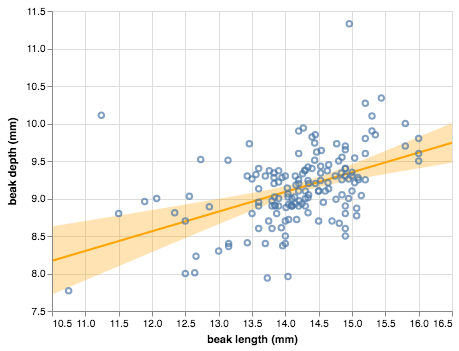

In [34]:
df_conf = pd.DataFrame({'x': x, 'high': high, 'low': low})

conf = alt.Chart(df_conf
    ).mark_area(
        color='orange',
        opacity=0.3
    ).encode(
        x=alt.X('x:Q', title='beak length (mm)', scale=alt.Scale(zero=False)),
        y=alt.Y('low:Q', title='beak depth (mm)', scale=alt.Scale(zero=False)),
        y2=alt.Y2('high:Q')
    )

(conf + reg_line + dots)